### Logins - Exploratory Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
from datetime import timedelta
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
base_dir = "data//"
file_name1 = "logins.json"
file_path1 = os.path.join(base_dir, file_name1)
with open(file_path1, "r") as read_file1:
    login = json.load(read_file1)

Text(0.5, 0, 'Hour of the Day')

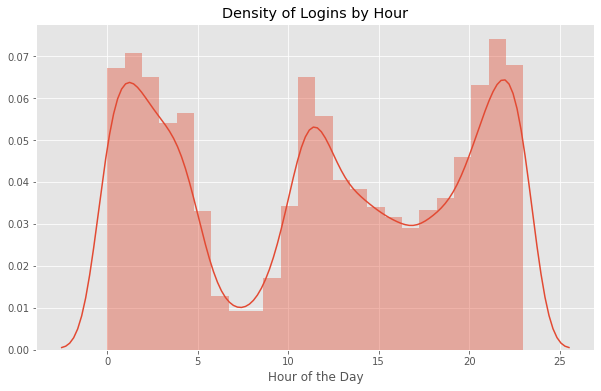

In [3]:
df_logs = pd.DataFrame(login)
df_logs['login_time'] = pd.to_datetime(df_logs['login_time']).sort_values().reset_index(drop = True)
#df_logs.set_index('login_time', inplace = True)
df_logs['num'] = 1
hour_series = df_logs.login_time.dt.strftime("%H").sort_values()
plt.figure(figsize = (10,6))
ax = sns.distplot(hour_series, bins =24, hist = True, kde = True )
ax.set_title("Density of Logins by Hour")
ax.set_xlabel('Hour of the Day')

The peak hours of logins start at 8 pm and continue until 5 am the next day. During the middle of the day, the logins are higher between 10 am and 12 noon. There is a drop in logins between 5 am and 10 am. 

Text(0.5, 1.0, 'Logins by Weekday')

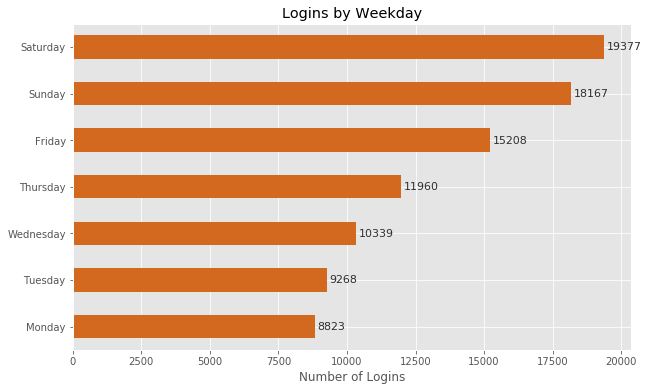

In [4]:
weekday_logins = df_logs.login_time.dt.day_name()
ax = weekday_logins.value_counts().plot(kind = 'barh', figsize = (10,6), color = 'chocolate')
y = weekday_logins.value_counts()
for i, v in enumerate(y):
    ax.text(v + 100, i, str(v), color='0.18',fontsize=11, ha='left', va='center')
ax.invert_yaxis()
ax.set_xlabel('Number of Logins')
ax.set_title('Logins by Weekday')

Saturday and Sunday are the days with most logins (busiest days) followed by friday. Monday, Tuesday and Wednesday are the days with fewer logins.

Text(0.5, 1.0, 'Daily Variations in Logins')

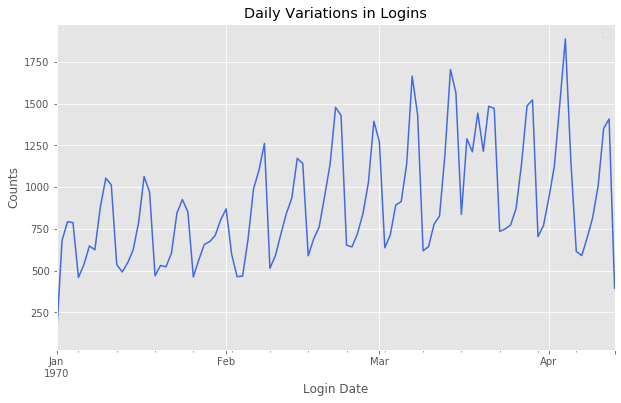

In [5]:
daily_logins = df_logs.set_index('login_time').resample('D').count()
daily_logins.plot(figsize = (10,6), color = 'royalblue' )
plt.legend('')
plt.ylabel('Counts')
plt.xlabel('Login Date')
plt.title('Daily Variations in Logins')

The above time series plot shows a weekly pattern and an upward trend. 

Text(0.5, 1.0, 'Weekly Logins Trend over Time')

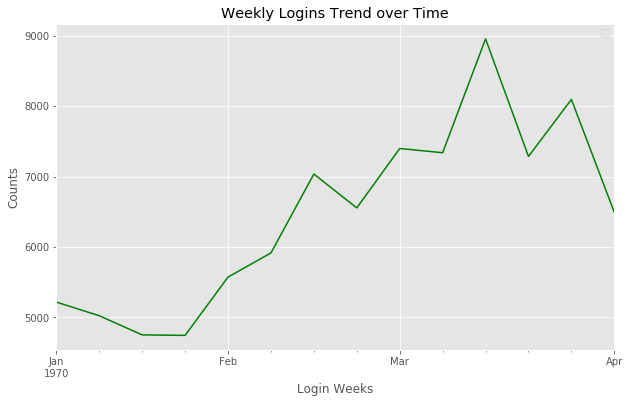

In [6]:
weekly_logins = df_logs.set_index('login_time').resample('W-MON', label = 'left', closed = 'left').count()
weekly_logins['1970-01-05':'1970-04-06'].plot(figsize = (10,6), color = 'green')
plt.legend("")
plt.xlabel('Login Weeks')
plt.ylabel('Counts')
plt.title('Weekly Logins Trend over Time')

There is an upward trend in the number of logins by week from january to mid march and a dip in the logins during the first week of April. Further investigation on the cause for the dip in April needs to be considered. 

With more data we can look if there exists any seasonality in the year and compare the numbers with that of previous years to get a better understanding of the trends in the logins.


### Predictive Modeling

In [7]:
base_dir = "data//"
file_name = "ultimate_data_challenge.json"
file_path = os.path.join(base_dir, file_name)
with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [8]:
dat = pd.DataFrame(data)
dat.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
dat.signup_date = pd.to_datetime(dat.signup_date)
dat.last_trip_date = pd.to_datetime(dat.last_trip_date)
dat.describe(include = 'all') 

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,50000,50000.000000,50000,41878.000000,50000.000000,50000,49604,50000.000000,50000,50000.000000,50000.000000,49799.000000
unique,3,NaN,31,NaN,NaN,182,2,NaN,2,NaN,NaN,NaN
top,Winterfell,NaN,2014-01-18 00:00:00,NaN,NaN,2014-06-29 00:00:00,iPhone,NaN,False,NaN,NaN,NaN
freq,23336,NaN,2948,NaN,NaN,2036,34582,NaN,31146,NaN,NaN,NaN
first,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2014-01-31 00:00:00,NaN,NaN,2014-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.278200,NaN,4.601559,1.074764,NaN,NaN,8.849536,NaN,60.926084,5.796827,4.778158
std,NaN,3.792684,NaN,0.617338,0.222336,NaN,NaN,19.958811,NaN,37.081503,5.707357,0.446652
min,NaN,0.000000,NaN,1.000000,1.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,1.000000
25%,NaN,0.000000,NaN,4.300000,1.000000,NaN,NaN,0.000000,NaN,33.300000,2.420000,4.700000


In [10]:
df = dat[dat.last_trip_date.dt.month <= 6]
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [11]:
df.avg_rating_of_driver.mean()

4.601151260097532

Text(0.5, 0, 'Average distance in first 30 days after signup (in miles)')

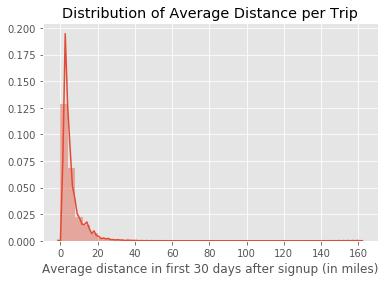

In [12]:
ax = sns.distplot(df['avg_dist'], kde = True, hist = True, bins = 40)
ax.set_title("Distribution of Average Distance per Trip")
ax.set_xlabel("Average distance in first 30 days after signup (in miles)")

Text(0, 0.5, 'Average Distance')

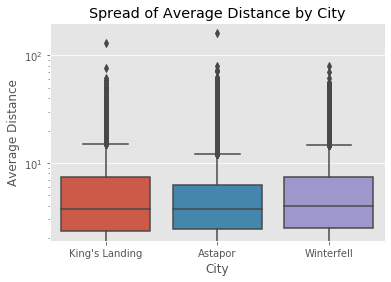

In [13]:
g = sns.boxplot(x = 'city',y = 'avg_dist',  data = df)
g.set_yscale('log')
g.set_title("Spread of Average Distance by City")
g.set_xlabel("City")
g.set_ylabel('Average Distance')

In [14]:
pd.crosstab(index = df['phone'], columns = df['city'], normalize = 'columns')

city,Astapor,King's Landing,Winterfell
phone,,,
Android,0.320829,0.250076,0.316128
iPhone,0.679171,0.749924,0.683872


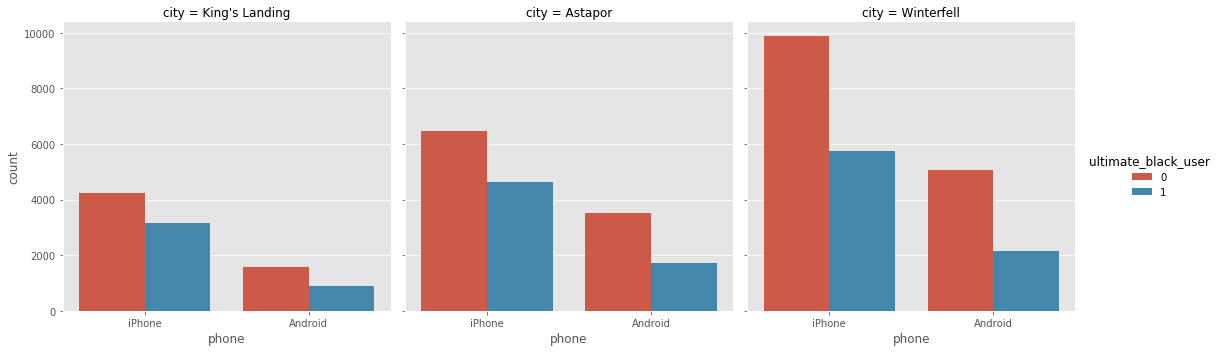

In [43]:
ax = sns.catplot(x= 'phone', hue="ultimate_black_user", col="city",data=df, kind="count")


In [16]:
pd.crosstab(index = df['ultimate_black_user'], columns = df['city'], normalize = 'columns')

city,Astapor,King's Landing,Winterfell
ultimate_black_user,,,
False,0.609492,0.586784,0.651061
True,0.390508,0.413216,0.348939


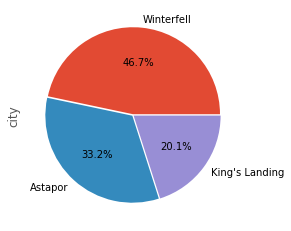

In [17]:
df.city.value_counts().plot.pie(autopct="%.1f%%",explode=[0.01]*3)

In [18]:
#date_range_first = max(df.last_trip_date) - timedelta(days = 30)
df['active']= 0

In [19]:
df.loc[(df.last_trip_date.dt.month == 6),'active'] = 1

In [20]:
perc_active = sum(df.active)/len(df)
str(round(perc_active*100, 2))+'%'+'of the people who signed up in Jan 2014 were active in their 6 month'

'36.92%of the people who signed up in Jan 2014 are active in their 6 month'

In [21]:
df.reset_index(inplace = True, drop = True)
df['days_since_sign_up'] = (df.last_trip_date - df.signup_date).dt.days
df = df.fillna(value=np.nan)

In [22]:
df['ultimate_black_user'] = df.ultimate_black_user.astype(int)

In [23]:
y = df.active
X = df.drop(columns = ['active', 'signup_date','last_trip_date'])
num_columns = X.select_dtypes(exclude = ['O']).columns
cat_columns = X.select_dtypes(include = ['O']).columns
X.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_sign_up
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,143
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,96
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,1
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,170
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,47


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,random_state = 18 )
X_train.shape, y_train.shape, X_test.shape

((44506, 11), (44506,), (4946, 11))

In [25]:
num_processor = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean')), ('scale', MinMaxScaler())])
cat_processor = Pipeline(steps = [('impute', SimpleImputer(strategy = 'most_frequent')), ('encode', OneHotEncoder())])
preprocessor = ColumnTransformer(transformers = [('num', num_processor, num_columns), ('cat', cat_processor, cat_columns)])

In [26]:
pipe = Pipeline([('data_preprocessing', preprocessor), ('classifier', LogisticRegression())])

In [27]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'days_since_sign_up'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('e

In [28]:
pipe.named_steps['data_preprocessing'].transformers_[1][1].named_steps['encode'].get_feature_names()


array(['x0_Astapor', "x0_King's Landing", 'x0_Winterfell', 'x1_Android',
       'x1_iPhone'], dtype=object)

In [29]:
LogisticRegression().get_params().keys()
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [30]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__C' : np.logspace(-2, 2, 4)},
    {'classifier' : [RandomForestClassifier()],
     'classifier__max_features' : ['sqrt','log2'],
    'classifier__criterion':['gini','entropy']}
]

In [31]:
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [32]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data_preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'days_since_sign_up'],
      dtyp...
                                                                         Index(['city', 'phone'], dtype='object'))])),
                       

In [33]:
clf.best_params_, clf.best_score_

({'classifier': LogisticRegression(C=4.6415888336127775),
  'classifier__C': 4.6415888336127775},
 0.9590842233691148)

In [34]:
best_model = clf.best_estimator_

In [35]:
y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9587545491306106

#### Feature coeffiecients

In [36]:
num_process = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean')), ('scale', MinMaxScaler())])
cat_process = Pipeline(steps = [('impute', SimpleImputer(strategy = 'most_frequent')), ('encode', OneHotEncoder())])

In [37]:
num_process.fit(X_train[num_columns])
X_train_num= num_process.transform(X_train[num_columns])
X_test_num = num_process.transform(X_test[num_columns])
X_test_scaled = pd.DataFrame(X_test_num, columns = num_columns,  index = X_test.index)
X_train_scaled = pd.DataFrame(X_train_num, columns = num_columns, index = X_train.index)
X_train[cat_columns] = X_train[cat_columns].transform(lambda x: x.fillna(x.mode().iloc[0]))
X_train_encode = pd.get_dummies(X_train[cat_columns])
X_test_encode = pd.get_dummies(X_test[cat_columns])
X_train_fin = pd.concat([X_train_scaled, X_train_encode], axis = 1)
X_test_fin = pd.concat([X_test_scaled, X_test_encode], axis = 1)
X_test_fin.shape, X_train_fin.shape

((4946, 14), (44506, 14))

In [38]:
lr = LogisticRegression(C=4.6415888336127775, random_state = 18)
model = lr.fit(X_train_fin, y_train)
y_pred = lr.predict(X_test_fin)
model.coef_, X_train_fin.columns, accuracy_score(y_test, y_pred)

(array([[ 6.46659184, -0.05628359,  1.97945538, -0.31468373,  0.82465669,
         -0.42282056,  0.62797063, -0.66609031, 35.101124  , -0.99505956,
          0.59526492, -0.6403388 , -0.93292321, -0.10721023]]),
 Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
        'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
        'avg_rating_by_driver', 'days_since_sign_up', 'city_Astapor',
        'city_King's Landing', 'city_Winterfell', 'phone_Android',
        'phone_iPhone'],
       dtype='object'),
 0.9587545491306106)

In [39]:
output = pd.DataFrame(model.coef_.reshape(-1,1), index = X_train_fin.columns, columns = ['coef'])
output['odds'] = np.exp(output['coef'])
output

,coef,odds
trips_in_first_30_days,6.466592,6.432876e+02
avg_rating_of_driver,-0.056284,9.452710e-01
avg_surge,1.979455,7.238800e+00
surge_pct,-0.314684,7.300197e-01
ultimate_black_user,0.824657,2.281097e+00
weekday_pct,-0.422821,6.551962e-01
avg_dist,0.627971,1.873804e+00
avg_rating_by_driver,-0.666090,5.137131e-01
days_since_sign_up,35.101124,1.754787e+15
city_Astapor,-0.995060,3.697014e-01


In [40]:
output.reset_index(inplace = True)
otpt = output.sort_values(by = 'odds', ascending = False)

Text(0.5, 1.0, 'Feature importance')

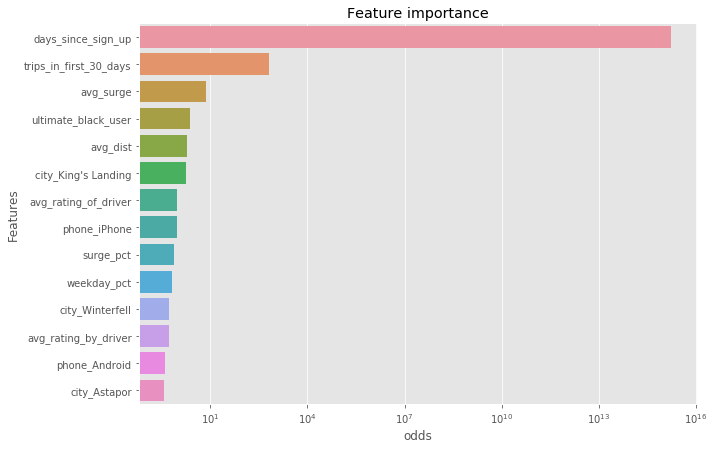

In [41]:
plt.subplots(figsize = (10,7))
ax = sns.barplot(x = 'odds', y = 'index', data = otpt)
ax.set_xscale('log')
ax.set_ylabel("Features")
ax.set_title("Feature importance")

The number of trips taken in the first 30 days highly influences rider retention. Active users have a higher average surge multiplier. Users from King’s landing are more likely to be retained compared to other cities.

Encouraging riders to sign up to be an Ultimate black user and take more trips in the first 30 days (by providing offers in the first month) can help improve rider retention. Identifying operational (or other) differences between the cities can help understand the cause for king’s landing’s upper hand among the three cities.  
